In [9]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.cluster import (
    v_measure_score,
    silhouette_score,
    davies_bouldin_score,
    homogeneity_score,
    adjusted_rand_score,
)
import plotly.express as px
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram
import io
import plotly.graph_objects as go
from IPython.display import clear_output

# Fonctions

In [2]:
def display_scree_plot(pca, X_red):
    """
    Cette fonction trace l'ébouli des valeurs propre et un scatter plot des données dans le premier plans principal
    """
    scree = pca.explained_variance_ratio_ * 100
    fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
    ax[0].bar(np.arange(len(scree)) + 1, scree)
    ax[0].plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    ax[0].set_xlabel("rang de l'axe d'inertie")
    ax[0].set_ylabel("pourcentage d'inertie")
    ax[0].set_title("Eboulis des valeurs propres")
    ax[1].scatter(X_red[:, 1], X_red[:, 0])
    ax[1].set_xlabel("2eme composante principale")
    ax[1].set_ylabel("1ère composante principale")
    ax[1].set_title("Représentation dans le plan principal")
    plt.show(block=False)


def display_circles(
    pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None
):
    """
    Cette fonction trace les cercles des corrélations
    """
    for (
        d1,
        d2,
    ) in (
        axis_ranks
    ):  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7, 6))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = (
                    min(pcs[d1, :]),
                    max(pcs[d1, :]),
                    min(pcs[d2, :]),
                    max(pcs[d2, :]),
                )

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(
                    np.zeros(pcs.shape[1]),
                    np.zeros(pcs.shape[1]),
                    pcs[d1, :],
                    pcs[d2, :],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="grey",
                )
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(
                    LineCollection(lines, axes=ax, alpha=0.1, color="black")
                )

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(
                            x,
                            y,
                            labels[i],
                            fontsize="14",
                            ha="center",
                            va="center",
                            rotation=label_rotation,
                            color="blue",
                            alpha=0.5,
                        )

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor="none", edgecolor="b")
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color="grey", ls="--")
            plt.plot([0, 0], [-1, 1], color="grey", ls="--")

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel(
                "F{} ({}%)".format(
                    d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)
                )
            )
            plt.ylabel(
                "F{} ({}%)".format(
                    d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)
                )
            )

            plt.title("Cercle des corrélations (F{} et F{})".format(d1 + 1, d2 + 1))
            plt.show(block=False)


def _invert(x, limits):
    """inverse la valeur x sur une échelle de limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])


def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverse si l'échelle est inversée"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)
    return sdata


class ComplexRadar:
    """
    Cette classe permet de tracer des radarplot avec plusieurs échelles pour chaque variable
    """

    def __init__(self, fig, variables, ranges, n_ordinate_levels=6):
        angles = np.arange(0, 360, 360.0 / len(variables))

        axes = [
            fig.add_axes([0.1, 0.1, 0.9, 0.9], polar=True, label="axes{}".format(i))
            for i in range(len(variables))
        ]
        l, text = axes[0].set_thetagrids(angles, labels=variables)
        axes[0].tick_params(pad=110)
        [txt.set_rotation(angle - 90) for txt, angle in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x, 2)) for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1]  # hack to invert grid
                # gridlabels aren't reversed
            gridlabel[0] = ""  # clean up origin
            ax.set_rgrids(grid, labels=gridlabel, angle=angles[i])
            # ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def standardize(dataset):
    """Standardise les données et retourne les données scalées"""
    X = dataset.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled


def standardize_0(dataset):
    """Standardise les données et retourne les données scalées et le scaler utilisé pour le scaling"""
    X = dataset.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return scaler, X_scaled

# Importation des données

In [3]:
customers = pd.read_csv("data/customers_cleaned_2.csv")
dataset = customers.iloc[:, 1:]
X_scaled = standardize(dataset)

In [4]:
customers.head()

,customer_unique_id,recency_customer,number_of_orders,payment_value,payment_installments,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,160.0,1,141.90,8.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163.0,1,27.19,1.0,4.0
2,0000f46a3911fa3c0805444483337064,585.0,1,86.22,8.0,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,369.0,1,43.62,4.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,336.0,1,196.89,6.0,5.0


# Dimensionality Reduction

## Principal Component Analysis

In [104]:
pca = PCA(n_components=5)
pca.fit(X_scaled)
X_red_pca = pca.transform(X_scaled)

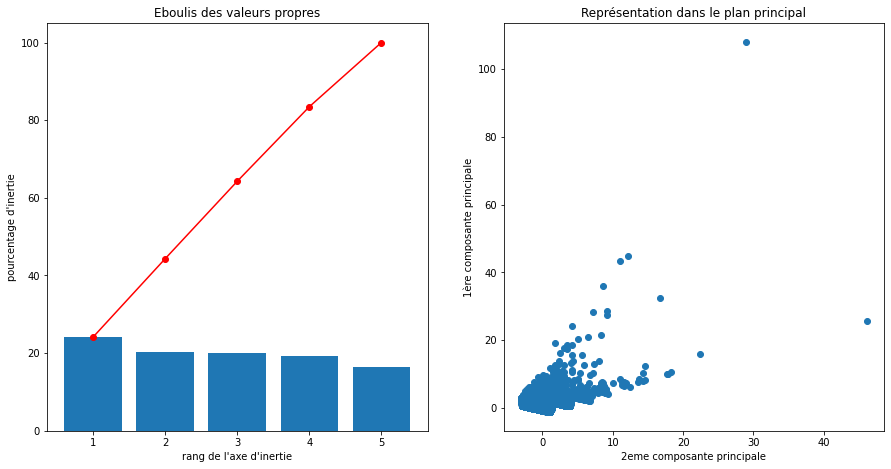

In [105]:
display_scree_plot(pca, X_red_pca)

Avec le PCA, il faut au moins 4 composantes principales pour povoir avoir une représentation fidèle de notre jeu de donnée. 

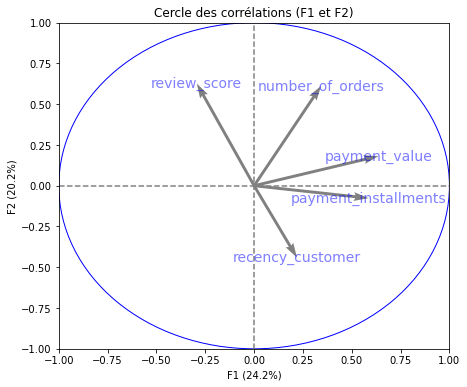

In [106]:
display_circles(
    pca.components_,
    5,
    pca,
    [(0, 1)],
    labels=dataset.columns,
    label_rotation=0,
    lims=None,
)

## Kernel PCA

Si on note $X=\{x_{i}\}_{i=1,...N} \in \mathbf{R}^{P} $ notre dataaset et qu'on suppose que les données sont centrées, i.e. $\frac{1}{N} \sum^{N}_{i=1} x_{i} = 0$, alors la matrice de covariance s'écrit :
\begin{equation}
    C = \frac{1}{N} \sum^{N}_{i=1} {x_i}{x_i}^T
\end{equation}
On suppose qu'il existe une fonction $\phi$ permettant de cartographier nos données dans un espace non linéaire et telle que $\frac{1}{N} \sum^{N}_{i=1} \phi(x_{i}) = 0$. On a alors une nouvelle matrice de covariance :
\begin{equation}
    \bar{C} = \frac{1}{N} \sum^{N}_{i=1} {\phi(x_i)}{\phi(x_i)}^T
\end{equation}

Le kernel trick consiste à ramener le calcul des directions principales de cette matrice de covariance à celle de la matrice K (kernel) définie par :

\begin{equation}
    K = \{\phi(x_i)~.~\phi(x_j)\}_{i,j = 1,...,N}~\in~\mathbf{R}^{N \times N}
\end{equation}

On constate ici que la résolution implique le calcul et le stockage en mémoire d'une matrice de taille $N$ x $N$, on a donc une complexité mémoire en $O(N²)$.
Nous allons montrer que cet algorithme ne convient pas à notre dataset de 100000 clients.

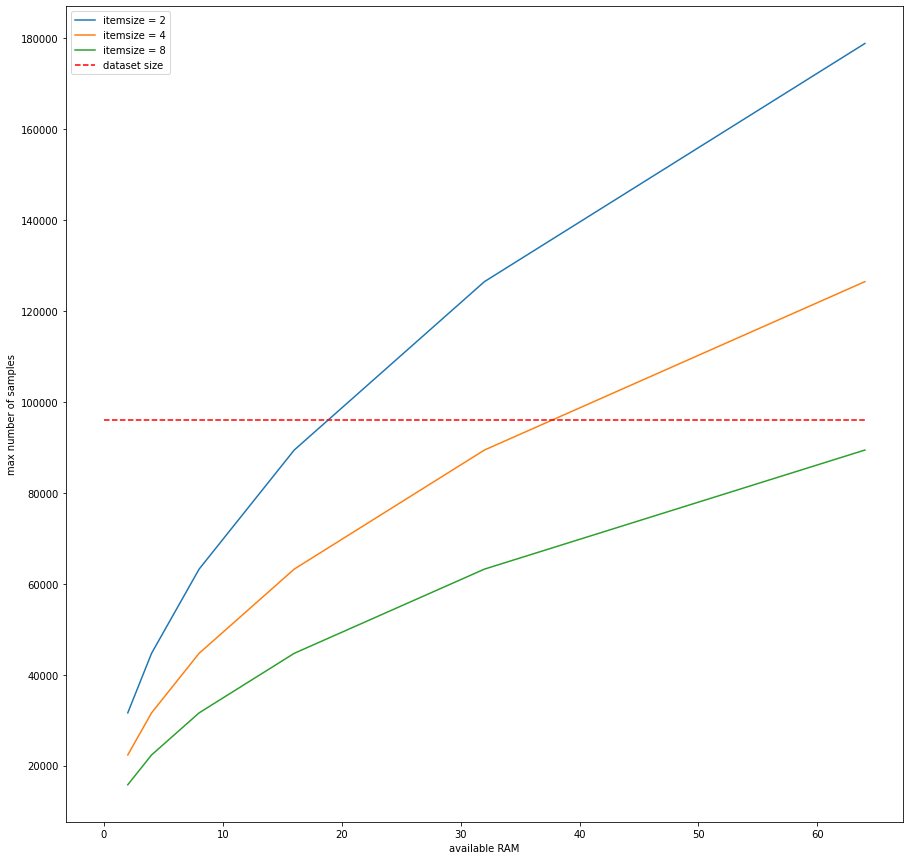

In [124]:
single_value_size = np.array([0.58], dtype="float32").itemsize


def max_number_of_sample(ram, size):
    return np.sqrt(1e9 * ram / size)


fig, ax = plt.subplots(figsize=(15, 15))
for size in [2, 4, 8]:
    ax.plot(
        [2, 4, 8, 16, 32, 64],
        [max_number_of_sample(x, size) for x in [2, 4, 8, 16, 32, 64]],
        linestyle="-",
        label="itemsize = " + str(size),
    )
ax.plot(
    [0, 64],
    [dataset.shape[0], dataset.shape[0]],
    linestyle="--",
    color="red",
    label="dataset size",
)
ax.legend()
ax.set_xlabel("available RAM")
ax.set_ylabel("max number of samples")
plt.show()

## Non Negativ Matrix Factorization

In [107]:
from sklearn.decomposition import NMF

model = NMF(n_components=5, init="random", max_iter=1000, random_state=0)
X = dataset.values
W = model.fit_transform(X)
H = model.components_
X_red_nmf = W

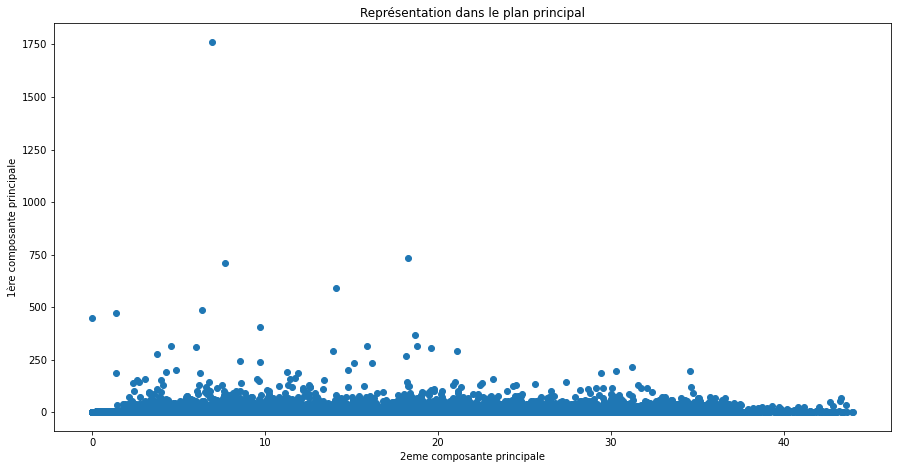

In [108]:
fig, ax = plt.subplots(figsize=(15, 7.5))
ax.scatter(W[:, 1], W[:, 0])
ax.set_xlabel("2eme composante principale")
ax.set_ylabel("1ère composante principale")
ax.set_title("Représentation dans le plan principal")
plt.show(block=False)

In [123]:
import plotly.express as px

df = pd.DataFrame(data=W, columns=["1", "2", "3", "4", "5"])
fig = px.scatter_3d(df, x="1", y="2", z="3")
fig.show()

Comme nous pouvons le voir cette méthode de réduction de dimension n\'offre pas une visualisation satisfaisante du jeu de
données.
Les points sont trop entassé pour pouvoir distinguer les clusters.

## T-Distributed Stochastic Neighbor Embedding

In [6]:
# t-SNE avec deux composantes
# si import = True, le résultat du t-SNE est importé, sinon il est recalculé
impor = True
if impor:
    X_red_tsne = np.loadtxt("x_red_tsne.csv", delimiter=",")
else:
    X_red_tsne = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(
        X_scaled
    )
# np.savetxt("/content/drive/MyDrive/OPENCLASSROOM/Projet5/x_red_tsne.csv", np.array(X_red_tsne), delimiter=',')

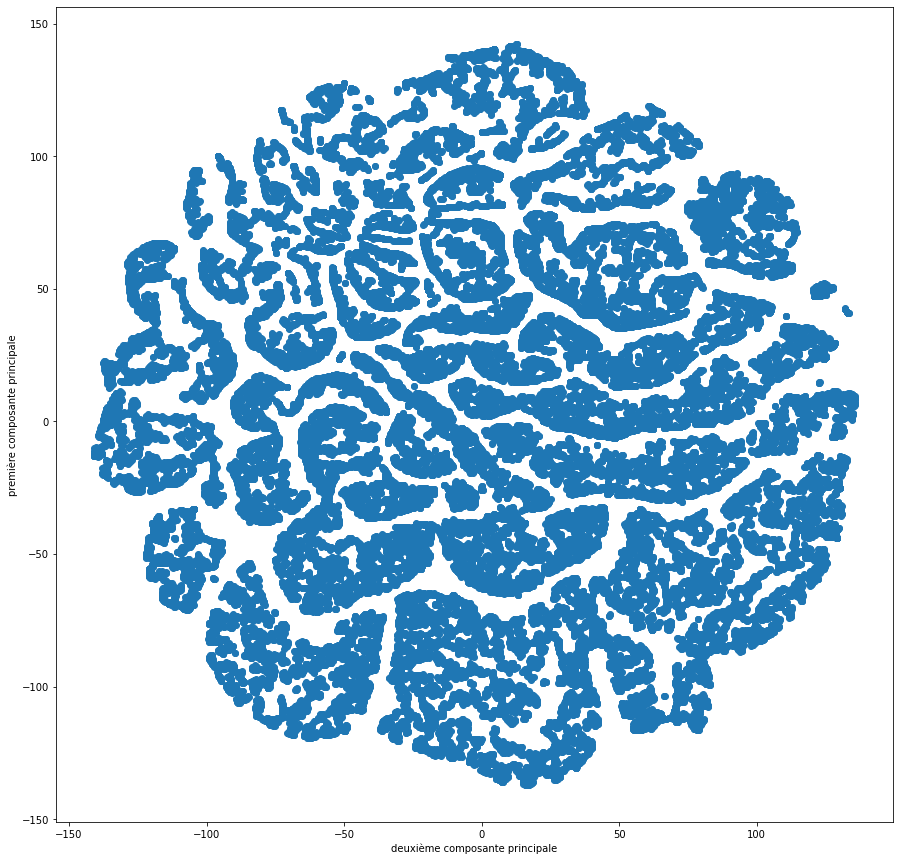

In [110]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X_red_tsne[:, 1], X_red_tsne[:, 0])
ax.set_xlabel("deuxième composante principale")
ax.set_ylabel("première composante principale")
plt.show()

In [11]:
# # t-SNE avec trois composantes
# # si import = True, le résultat du t-SNE est importé, sinon il est recalculé
# impor = True
# if (impor):
#     X_red_tsne_3d = np.loadtxt("x_red_tsne_3d.csv", delimiter=',')
# else:
#     X_red_tsne_3d = TSNE(n_components=3, learning_rate = 'auto', init='pca').fit_transform(X_scaled)
# df = pd.DataFrame(data=X_red_tsne_3d,columns=["1","2","3"])
# fig = px.scatter_3d(df, x='1', y='2', z='3', color = true_labels_kmeans)
# fig.show()

Le t-SNE fournit une représentation bien plus propice à la visualisation des clusters. Nous retenons cet algorithme pour 
la réduction de nos données.

# Clustering

## DB-SCAN

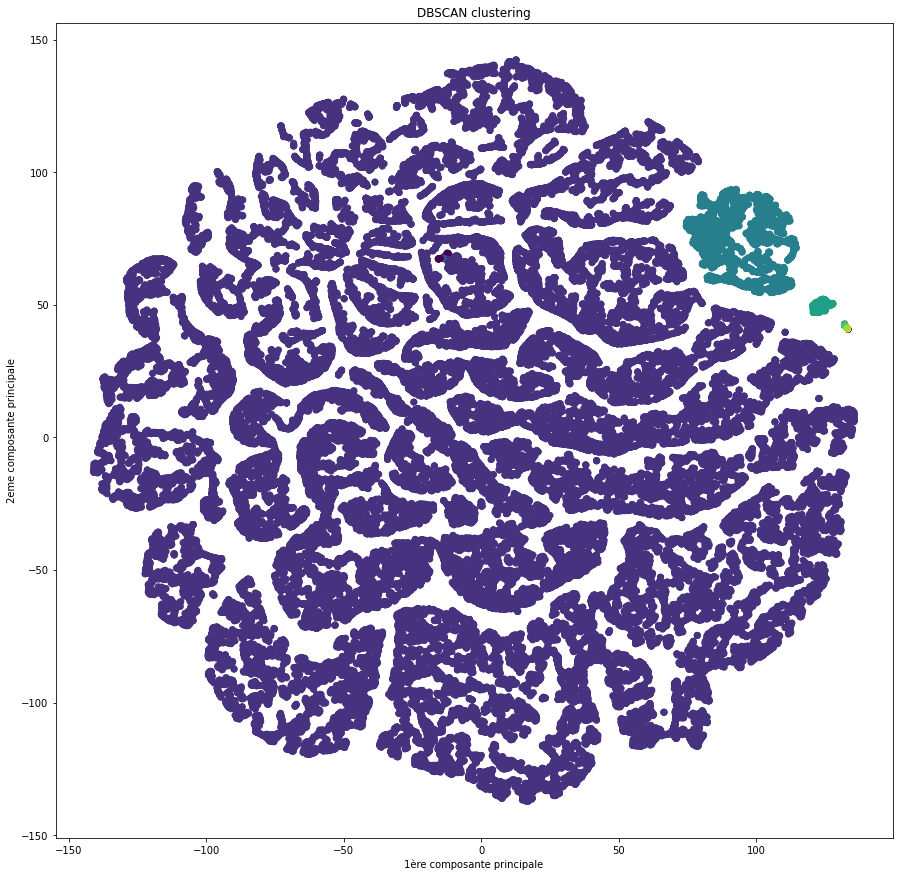

In [88]:
# Tentative d'utilisation du DBSCAN
clustering = OPTICS(min_samples=5, cluster_method="dbscan", eps=3).fit(X_scaled)
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X_red_tsne[:, 1], X_red_tsne[:, 0], c=clustering.labels_)
ax.set_xlabel("1ère composante principale")
ax.set_ylabel("2eme composante principale")
ax.set_title("DBSCAN clustering")
plt.show(block=False)

Malgré plusieurs tentative, le dbscan ne parviens pas à créer des clusters équillibrés. 

# Ward Clustering

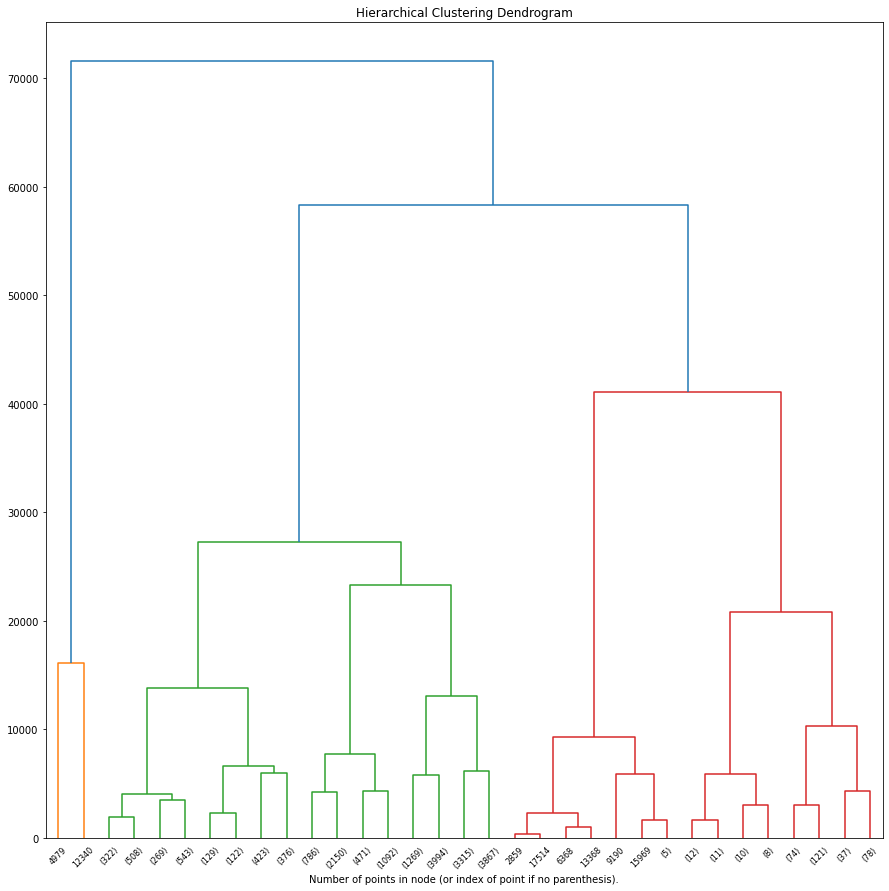

In [128]:
# Clustering de Ward sur un sous échantillon
X = dataset.values
X = X[np.random.randint(0, X.shape[0], size=(20000,)), :]

# setting distance_threshold = 0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X)

# model = model.fit(np.array(X,dtype="float32"))
plt.subplots(figsize=(15, 15))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Malheureusement, le clustering de Ward devient innapplicaple à notre jeu de données complet pour des raisons de limitations 
mémoire.

## K_Means

### Choix du nombre de cluster

In [90]:
# calcul des coefficients de silhouettes
sil_coeffs = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(X_scaled)
    sil_coeffs.append(silhouette_score(X_scaled, kmeans.labels_))

In [91]:
# calcul des coefficients de davies bouldin
davies_bouldin_coeffs = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42).fit(X_scaled)
    davies_bouldin_coeffs.append(davies_bouldin_score(X_scaled, kmeans.labels_))

In [92]:
# calcul des coefficients de silhouettes
ch_coeffs = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42).fit(X_scaled)
    ch_coeffs.append(calinski_harabasz_score(X_scaled, kmeans.labels_))

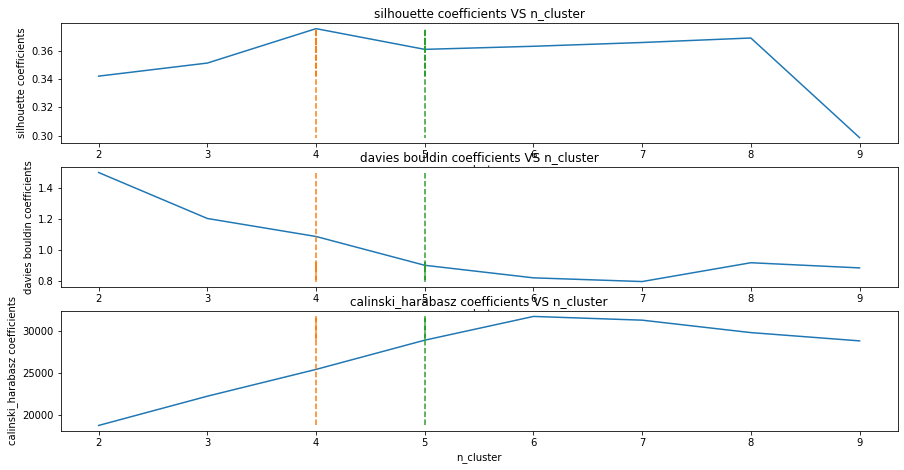

In [ ]:
# Evolution des métriques en fonction du nombre de cluster
fig, ax = plt.subplots(3, 1, figsize=(15, 7.5))

ax[0].plot(range(2, 10), sil_coeffs, linestyle="-")
ax[0].plot([4 for x in range(2, 10)], sil_coeffs, linestyle="--")
ax[0].plot([5 for x in range(2, 10)], sil_coeffs, linestyle="--")
ax[0].set_xlabel("n_cluster")
ax[0].set_ylabel("silhouette coefficients")
ax[0].set_title("silhouette coefficients VS n_cluster")

ax[1].plot(range(2, 10), davies_bouldin_coeffs, linestyle="-")
ax[1].plot([4 for x in range(2, 10)], davies_bouldin_coeffs, linestyle="--")
ax[1].plot([5 for x in range(2, 10)], davies_bouldin_coeffs, linestyle="--")
ax[1].set_xlabel("n_cluster")
ax[1].set_ylabel("davies bouldin coefficients")
ax[1].set_title("davies bouldin coefficients VS n_cluster")

ax[2].plot(range(2, 10), ch_coeffs, linestyle="-")
ax[2].plot([4 for x in range(2, 10)], ch_coeffs, linestyle="--")
ax[2].plot([5 for x in range(2, 10)], ch_coeffs, linestyle="--")
ax[2].set_xlabel("n_cluster")
ax[2].set_ylabel("calinski_harabasz coefficients")
ax[2].set_title("calinski_harabasz coefficients VS n_cluster")

plt.show()

### Etude de stabilité

In [5]:
n_cluster = 5
kmeans = KMeans(n_clusters=n_cluster).fit(X_scaled)
true_labels_kmeans = kmeans.labels_
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
counter = 0
rand_scores = []
for i in range(9):
    kmeans = KMeans(n_clusters=n_cluster, init="random").fit(X_scaled)
    pred_labels_kmeans = kmeans.labels_
    rand_scores.append(adjusted_rand_score(true_labels_kmeans, pred_labels_kmeans))
    ax[counter // 3, counter % 3].scatter(
        X_red_tsne[:, 1],
        X_red_tsne[:, 0],
        c=kmeans.labels_,
        label="rand = "
        + str(round(adjusted_rand_score(true_labels_kmeans, pred_labels_kmeans), 5)),
    )
    ax[counter // 3, counter % 3].legend()
    counter += 1

## Analyse des Cluster

### Taille des clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


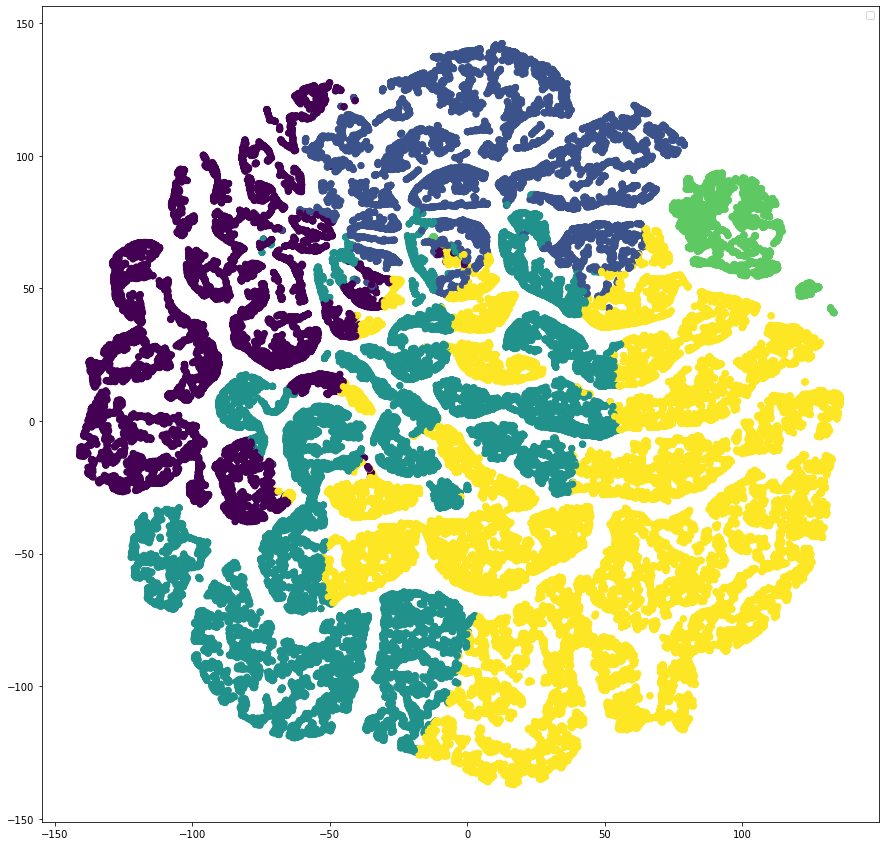

In [89]:
n_cluster = 5
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X_red_tsne[:, 1], X_red_tsne[:, 0], c=true_labels_kmeans)
ax.legend()
plt.show()

In [7]:
dataset_clustered = dataset.copy(deep=True)
dataset_clustered["cluster"] = true_labels_kmeans
dataset_clustered.groupby("cluster").mean()

,recency_customer,number_of_orders,payment_value,payment_installments,review_score
cluster,,,,,
0,171.646780,1.000000,146.180544,1.855575,4.656601
1,445.493087,1.000000,148.937285,2.030389,4.622955
2,291.025565,1.000000,214.747830,2.413520,1.536667
3,296.746099,1.000000,492.486838,8.399330,4.259332
4,311.857357,2.116116,487.140774,3.296588,4.106800


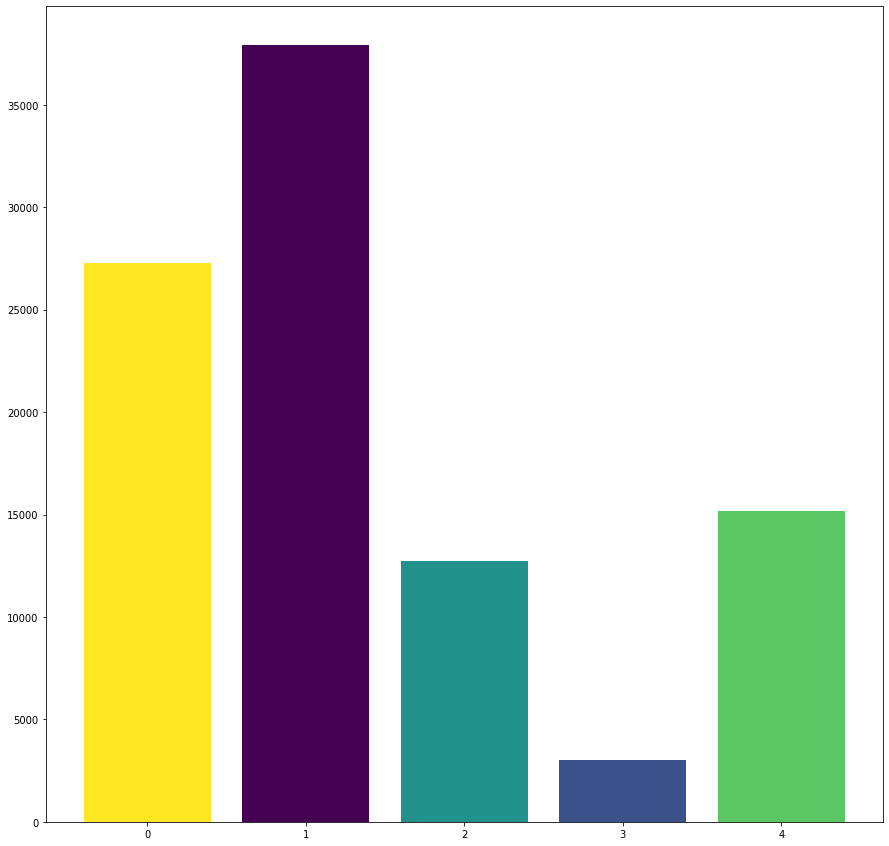

In [111]:
a = dataset_clustered["cluster"].value_counts()
fig, ax = plt.subplots(figsize=(15, 15))
ax.bar(a.index, a.values, color=["#440154", "#FDE725", "#5BC663", "#21918C", "#3B528B"])
plt.show()

### Caractérisation des clusters

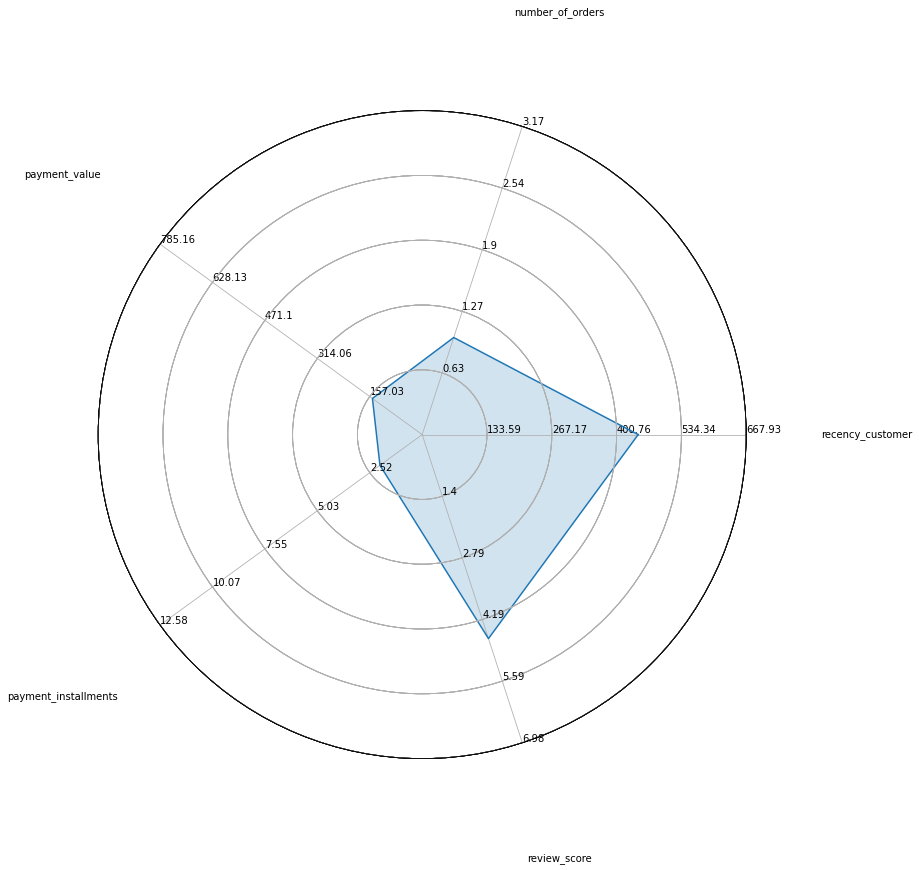

In [112]:
cluster = 0

dataset_clustered_0 = dataset_clustered[dataset_clustered["cluster"] == cluster]
means = dataset_clustered_0.mean().iloc[:-1]
labels = tuple(means.index)
values = tuple(means.values)
ranges = [
    (0, 1.5 * x)
    for x in dataset_clustered.groupby("cluster")
    .mean()
    .reset_index(drop=True)
    .max()
    .values
]

# example data
variables = labels
data = values
# ranges = [(0.1, 2.3), (0, 1.5), (0, 1.8), (1.7, 4.5), (1.5, 3.7), (70, 87), (100, 10)]
# plotting
fig1 = plt.figure(figsize=(10, 10))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()

Le cluster 0 apparait comme le cluster des clients anciens.

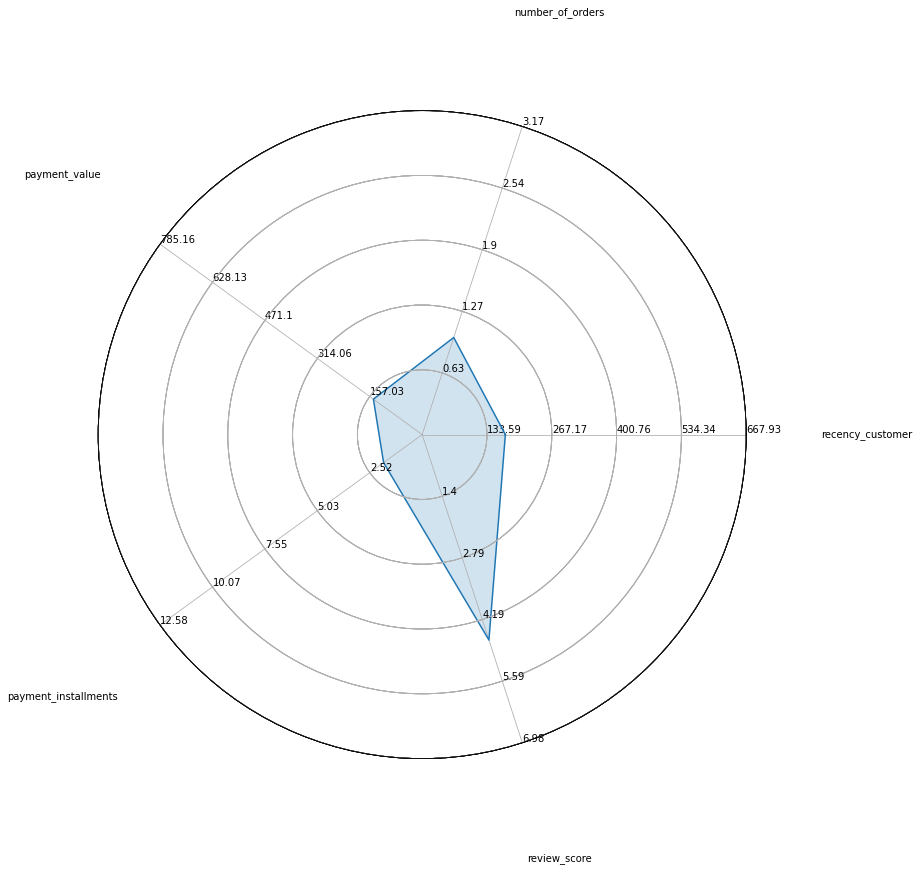

In [113]:
cluster = 1

dataset_clustered_0 = dataset_clustered[dataset_clustered["cluster"] == cluster]
means = dataset_clustered_0.mean().iloc[:-1]
labels = tuple(means.index)
values = tuple(means.values)
ranges = [
    (0, 1.5 * x)
    for x in dataset_clustered.groupby("cluster")
    .mean()
    .reset_index(drop=True)
    .max()
    .values
]

# example data
variables = labels
data = values
# ranges = [(0.1, 2.3), (0, 1.5), (0, 1.8), (1.7, 4.5), (1.5, 3.7), (70, 87), (100, 10)]
# plotting
fig1 = plt.figure(figsize=(10, 10))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()

Le cluster 1 apparait comme le cluster des clients récents. Il peut être intéressant de leurs recommander des offres en lien
avec leurs précédentes commandes

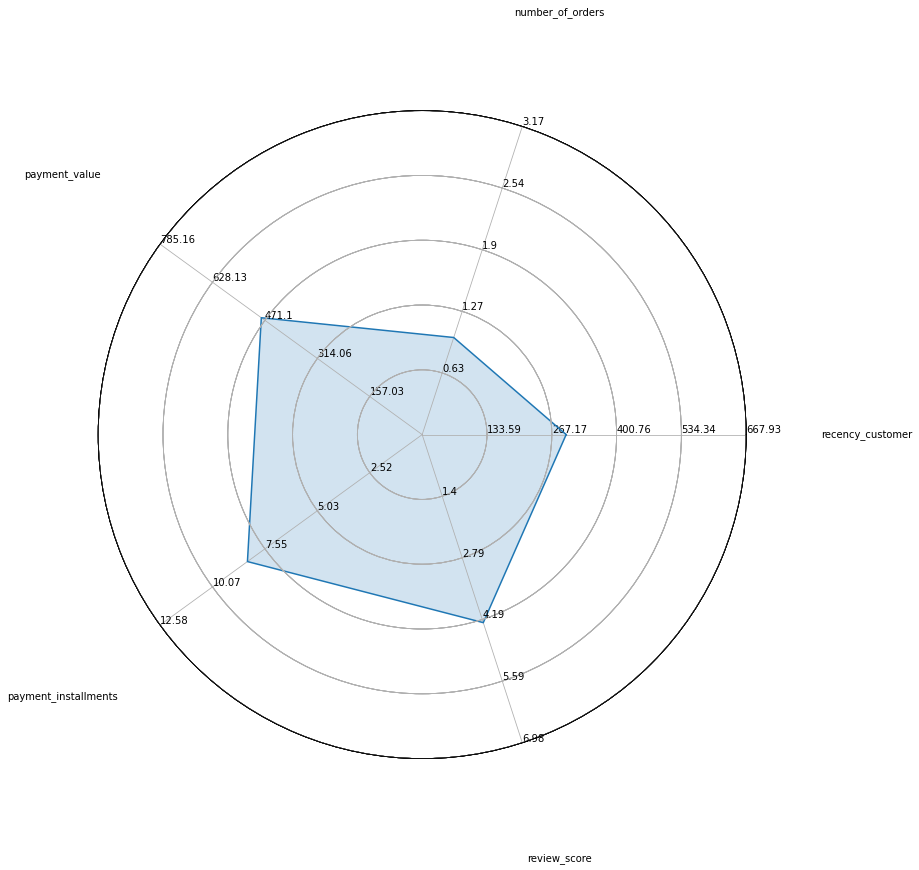

In [119]:
cluster = 2

dataset_clustered_0 = dataset_clustered[dataset_clustered["cluster"] == cluster]
means = dataset_clustered_0.mean().iloc[:-1]
labels = tuple(means.index)
values = tuple(means.values)
ranges = [
    (0, 1.5 * x)
    for x in dataset_clustered.groupby("cluster")
    .mean()
    .reset_index(drop=True)
    .max()
    .values
]

# example data
variables = labels
data = values
# ranges = [(0.1, 2.3), (0, 1.5), (0, 1.8), (1.7, 4.5), (1.5, 3.7), (70, 87), (100, 10)]
# plotting
fig1 = plt.figure(figsize=(10, 10))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()

Le cluster 2 apparait comme le cluster des bons payeurs intermittents (montants élevés mais nombre d'échéance de payements 
élevés aussi )

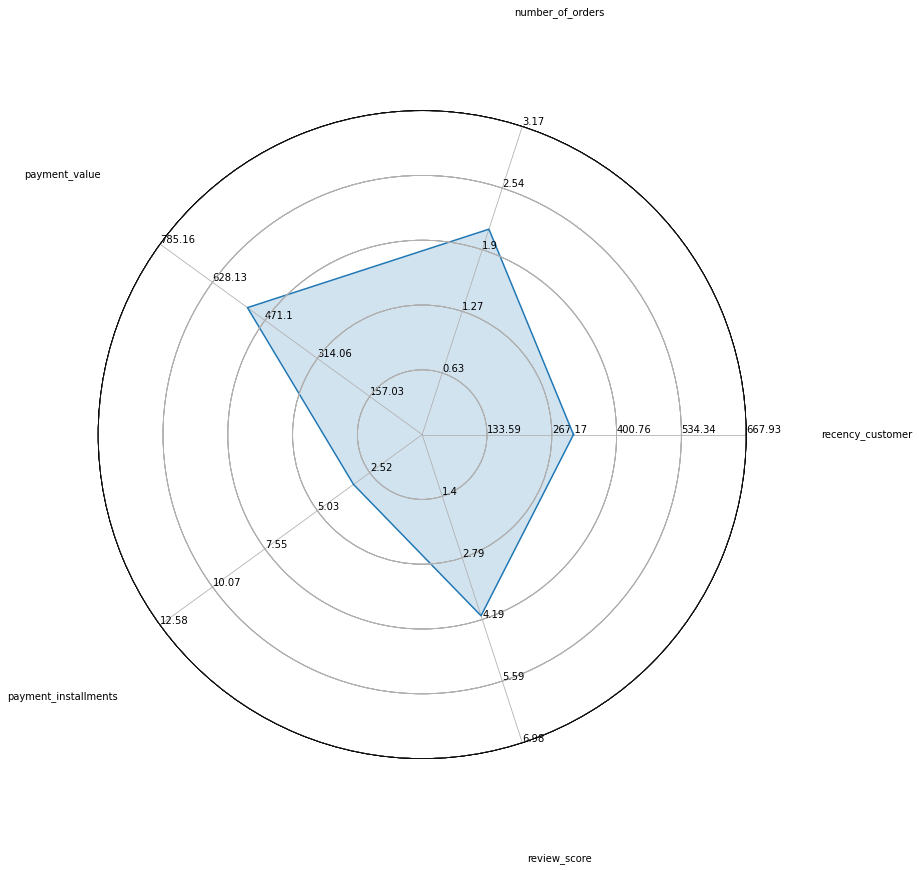

In [115]:
cluster = 3

dataset_clustered_0 = dataset_clustered[dataset_clustered["cluster"] == cluster]
means = dataset_clustered_0.mean().iloc[:-1]
labels = tuple(means.index)
values = tuple(means.values)
ranges = [
    (0, 1.5 * x)
    for x in dataset_clustered.groupby("cluster")
    .mean()
    .reset_index(drop=True)
    .max()
    .values
]

# example data
variables = labels
data = values
# ranges = [(0.1, 2.3), (0, 1.5), (0, 1.8), (1.7, 4.5), (1.5, 3.7), (70, 87), (100, 10)]
# plotting
fig1 = plt.figure(figsize=(10, 10))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()

Le cluster 3 apparait comme le cluster des "très bon clients". (montant élevés, peu d'échéances, fréquence élevée, fréquence
élevée)
Des clients à fidéliser absolument !

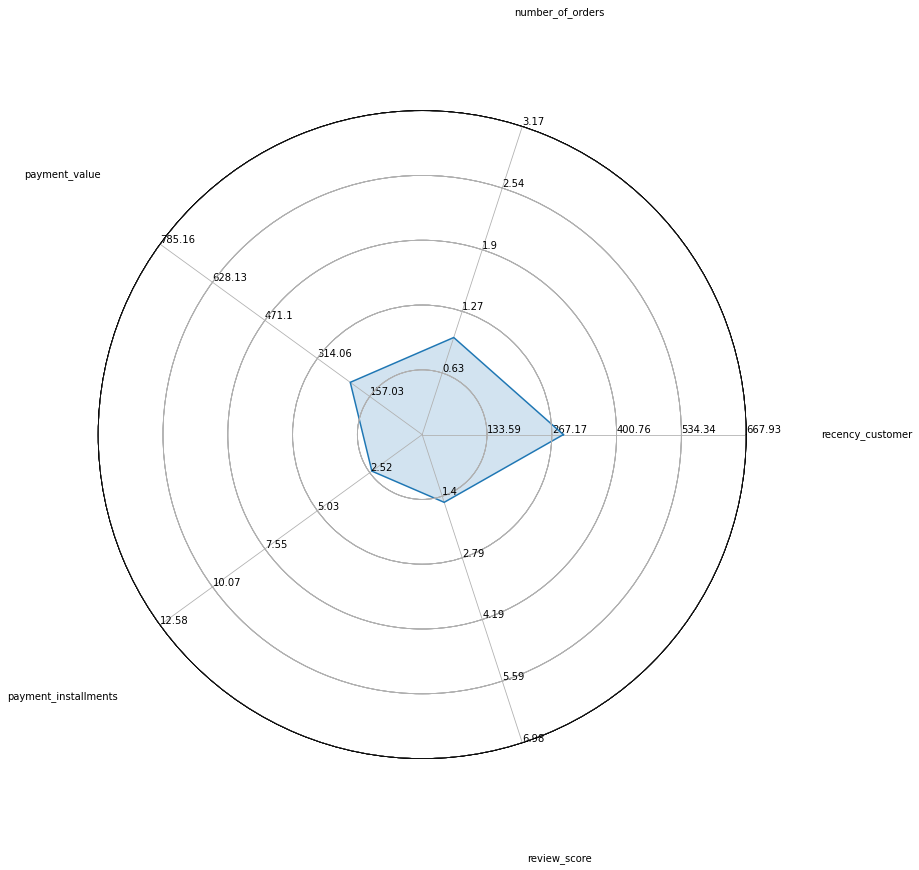

In [116]:
cluster = 4

dataset_clustered_0 = dataset_clustered[dataset_clustered["cluster"] == cluster]
means = dataset_clustered_0.mean().iloc[:-1]
labels = tuple(means.index)
values = tuple(means.values)
ranges = [
    (0, 1.5 * x)
    for x in dataset_clustered.groupby("cluster")
    .mean()
    .reset_index(drop=True)
    .max()
    .values
]

# example data
variables = labels
data = values
# ranges = [(0.1, 2.3), (0, 1.5), (0, 1.8), (1.7, 4.5), (1.5, 3.7), (70, 87), (100, 10)]
# plotting
fig1 = plt.figure(figsize=(10, 10))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()

Le cluster 4 est le cluster des clients insatisfaits. Il peut être intéressant de leur envoyé un questionnaire pour 
comprendre les raisons de leurs mécontentements.